# Eigen Portfolios

In [1]:
%load_ext autoreload
%autoreload 2  

import numpy as np
import pandas as pd
import yfinance as yf
import functions as f
import matplotlib.pyplot as plt
import datetime as dt
import funcoes as f
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
pd.set_option('display.max_rows', 500)

In [2]:
stock_prices = pd.read_csv('precos.csv', sep=';', index_col='Date')
# stock_prices = pd.read_csv('precos.csv', sep=';', index_col='Date').iloc[ : , :16].drop('BOVA11.SA', axis='columns')
benchmark = stock_prices['BOVA11.SA']
stock_prices.drop('BOVA11.SA', axis=1, inplace=True)

Benchmark Done
EW Done
Eigen Done
PCA Done


,Annualized Return,Annualized Vol,Sharpe Ratio,Sortino Ratio,Average Drawdown,Max Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%)
BOVA11,6.67,23.13,0.28847,0.54046,-9.48,-37.65,-0.74857,6.27378,11.07,14.51
EW,14.29,22.85,0.62530,0.97542,-7.18,-35.37,-0.65041,6.40049,10.18,13.09
Eigen,17.24,27.07,0.63683,1.08246,-7.29,-38.02,-0.44961,5.34981,11.75,14.92
PCA,16.23,31.27,0.51897,1.13309,-8.37,-37.10,0.78649,6.40479,10.41,16.43


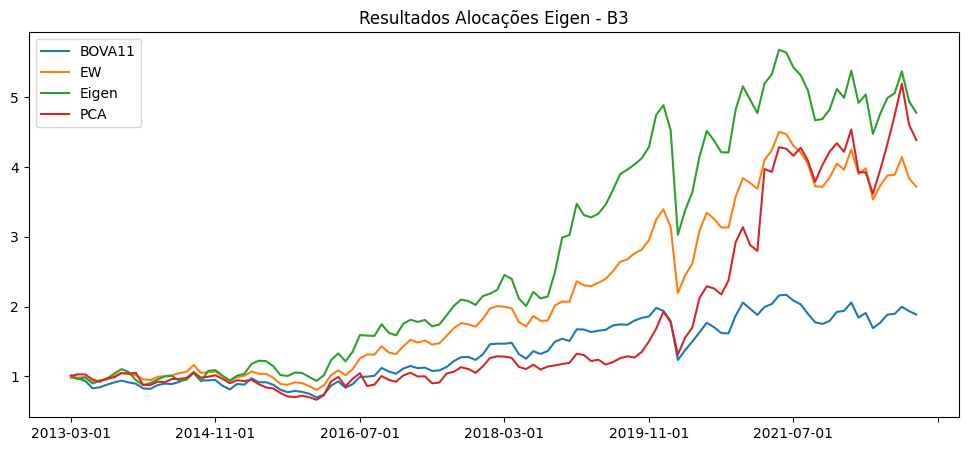

In [3]:
periodos = 36
oos = 1

bova = f.returns(pd.read_csv('precos.csv', sep=';', index_col='Date')['BOVA11.SA']);print('Benchmark Done')
rets_ew = f.pipeline(stock_prices, periodos, oos, algo=f.weight_ew);print('EW Done')
rets_eigen = f.pipeline(stock_prices, periodos, oos, algo=f.weight_eigen);print('Eigen Done')
rets_pca = f.pipeline(stock_prices, periodos, oos, algo=f.weight_pca);print('PCA Done')

eigen_portfolios_results = pd.DataFrame(
    {
        "BOVA11": bova[rets_ew.index.min():],
        "EW": rets_ew['rets'],
        "Eigen": rets_eigen['rets'],
        "PCA": rets_pca['rets'],
    }
)

(1+eigen_portfolios_results).cumprod().plot(figsize=(12,5), title="Resultados Alocações Eigen - B3");
f.summary_stats(eigen_portfolios_results, 0)

In [4]:
eigen_portfolios_results.corr()

,BOVA11,EW,Eigen,PCA
BOVA11,1.000000,0.946624,0.883377,0.769282
EW,0.946624,1.000000,0.910981,0.811280
Eigen,0.883377,0.910981,1.000000,0.728768
PCA,0.769282,0.811280,0.728768,1.000000


### LONG-ONLY

In [5]:
def weight_pca_long(df, cov_estimator=f.sample_cov, **kwargs):
    rets = (df - df.mean()) / df.std()
    cov_matrix = cov_estimator(rets)
        
    pca = PCA()
    pca_fitted = pca.fit(cov_matrix)
    
    pca_comp = pca_fitted.components_;
    pc_w = pca_comp
    pc_w[pc_w < 0] = int(0.0001) ## tira os valores negativos, para ser long only

    stats = f.summary_stats(pd.DataFrame(pc_w),0).sort_values('Sharpe Ratio', ascending=False)
    max_port = stats.index[stats['Sharpe Ratio'] == stats['Sharpe Ratio'].max()][0]
    res = pc_w[:,max_port] / np.sum(pc_w[:,max_port]) # Normaliza para soma ser igual a 1 (evitar alavangcagem)
    return res

def weight_eigen_long(df, cov_estimator=f.sample_cov, **kwargs):
    rets = (df - df.mean()) / df.std()
    cov_matrix = cov_estimator(rets)
    
    D, pc_w = np.linalg.eigh(cov_matrix)
    pc_w[pc_w < 0] = int(0.0001) ## tira os valores negativos, para ser long only

    stats = f.summary_stats(pd.DataFrame(pc_w),0).sort_values('Sharpe Ratio', ascending=False)
    max_port = stats.index[stats['Sharpe Ratio'] == stats['Sharpe Ratio'].max()][0]
    res = pc_w[:,max_port] / np.sum(pc_w[:,max_port]) # Normaliza para soma ser igual a 1 (evitar alavangcagem)
    return res

Benchmark Done
EW Done
Eigen_long Done
PCA_long Done


,Annualized Return,Annualized Vol,Sharpe Ratio,Sortino Ratio,Average Drawdown,Max Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%)
BOVA11,6.67,23.13,0.28847,0.54046,-9.48,-37.65,-0.74857,6.27378,11.07,14.51
EW,14.29,22.85,0.62530,0.97542,-7.18,-35.37,-0.65041,6.40049,10.18,13.09
Eigen Long,12.52,24.80,0.50487,0.84028,-8.29,-37.68,-0.61590,6.38694,11.18,14.43
PCA Long,12.23,24.26,0.50415,0.85501,-7.84,-36.35,-0.58730,6.23021,10.92,13.87


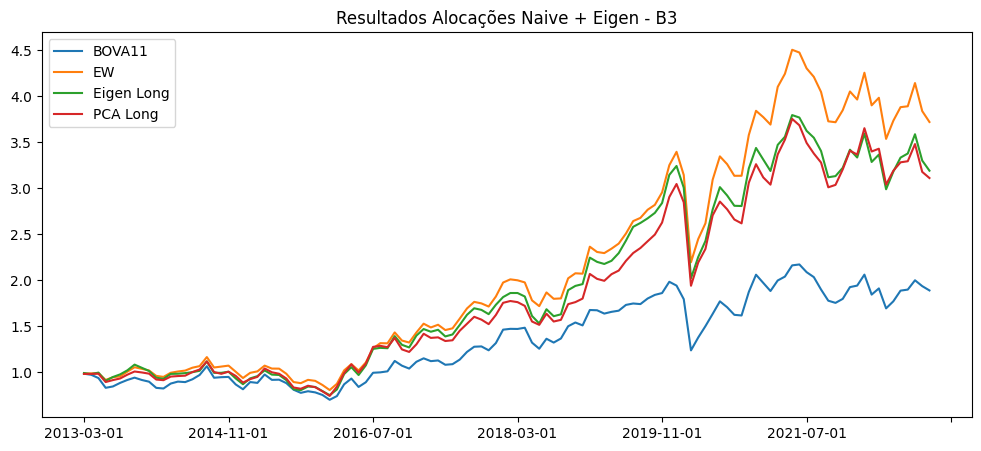

In [7]:
periodos = 36
oos = 1

bova = f.returns(pd.read_csv('precos.csv', sep=';', index_col='Date')['BOVA11.SA']);print('Benchmark Done')
rets_ew = f.pipeline(stock_prices, periodos, oos, algo=f.weight_ew);print('EW Done')
rets_eigen_long = f.pipeline(stock_prices, periodos, oos, algo=weight_eigen_long);print('Eigen_long Done')
rets_pca_long = f.pipeline(stock_prices, periodos, oos, algo=weight_pca_long);print('PCA_long Done')

naive_portfolios_results = pd.DataFrame(
    {
        "BOVA11": bova[rets_ew.index.min():],
        "EW": rets_ew['rets'],
        "Eigen Long": rets_eigen_long['rets'],
        "PCA Long": rets_pca_long['rets'],
    }
)

(1+naive_portfolios_results).cumprod().plot(figsize=(12,5), title="Resultados Alocações Naive + Eigen - B3");
f.summary_stats(naive_portfolios_results, 0)